# Eigenvector Spatial Filtering

Let's explore the concept of eigenvector spatial filtering. The concept of eigenvectors is most commonly associated with linear matrix operations. As many statistical models have been defined upon matrix concepts, many practical applications for eigenvectors have been identified in statistical analysis. 

Eigenvectors refer to the principal, proper, or prime vector as defined from any particular point in a space. In the context of spatial applications, consider a spatial weights matrix. As has been discussed, the spatial weights matrix represents that neighborhood relationships that can somehow influence a phenonomenon at a particular location i. Given a spatial weights matrix, for any location j in i's neighborhood, a vector exists...this is an eigenvector. The extent to which that vector can be increased or decreased is known as an eigenvalue. As applied to spatial autocorrelation, different eigenvectors within a spatial weights matrix are known to exhibit different qualities or components of spatial autocorrelation. Some of these eigenvectors reflect stronger patterns of autocorrelation while others reflect little or no autocorrelation (i.e. randomness). 

In [66]:
# Load relevant R packages
inLibraries = list('rgdal','spdep','classInt','RColorBrewer','MASS')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

In [67]:
#Read in the featureclass
inFeatures <- readOGR("/dsa/data/geospatial/DS8612/usagriculture", "usfarming")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/usagriculture", layer: "usfarming"
with 3070 features
It has 93 fields


## Subset Features

While this dataset is not 'big data' by any stretch of the imagination, it's large enough that working with it on a remote server can be slow. As such, let's select a specific state to analyze - California, in the interest of time. 

Note, that state names are not explicitly included in the dataset. However, the FIPS code for each county is provided. Typically, the first two digits of a Fips code reflect the state id number while the last three reflect a specific county within a state.  For more on fips codes see http://www.nws.noaa.gov/mirs/public/prods/maps/cnty_fips_def.htm. In this dataset, the 'atlas_stco' field contains the fips code as a character variable. Thus, in order to select the first two characters associated with a particular state, we need some way to match one portion of a string to another. There are several ways to do this. In this case, first a new field is added to the dataframe 'stcode' and populated with the first two characters in the 'atlas_stco' field which is the fips code. Next, grep() is used to select the fips code prefixes which correspond with the fips code of California ('06').

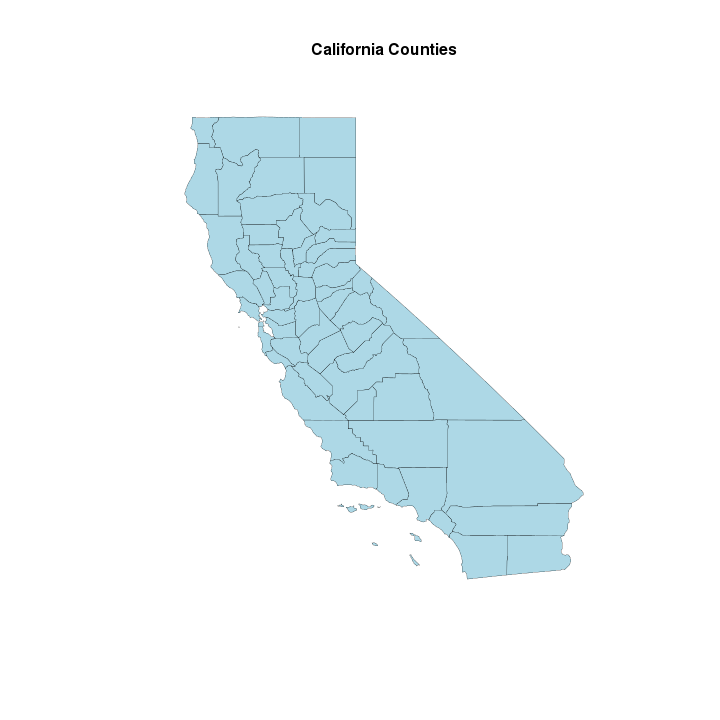

In [68]:
#add new column to dataframe and populate with first two numbers of fips code
inFeatures@data$stcode <- substr(inFeatures@data$atlas_stco, start=1, stop=2)

#select features with a state fips code beginning with...
inFeaturesSubsetA <- inFeatures[grep("06", inFeatures@data$stcode), ]

#plot the state selected
plot(inFeaturesSubsetA,col="lightblue", lwd=.2, main="California Counties",cex.main=.8)

## Generate Neighborhoods for Features¶

As before, generate neighborhoods for each feature. Then test the neighborhoods to see if they are valid. Retain only the features with valid neighborhoods.

In [69]:
#Identify the neighbors of each feature
inFeaturesSubsetA.nb <- poly2nb(inFeaturesSubsetA ,queen=TRUE)

head(inFeaturesSubsetA.nb)

[[1]]
[1]  7 39 41 43 50

[[2]]
[1]  3  5  9 26 55

[[3]]
[1]  2  5  9 34 39

[[4]]
[1]  6 11 32 51 52 58

[[5]]
[1]  2  3 39 50 55

[[6]]
[1]  4 11 17 51 57

In [70]:
length(inFeaturesSubsetA.nb)

[1] 58

In [71]:
#Select features with at least one neighbor
inFeaturesSubset <- inFeaturesSubsetA[card(inFeaturesSubsetA.nb) >= 1, ]

length(inFeaturesSubset)

[1] 58

In [72]:
#Identify the neighbors of each feature having at least one neighbor
inFeaturesSubset.nb <- poly2nb(inFeaturesSubset, queen=TRUE)

length(inFeaturesSubset.nb)

[1] 58

In [73]:
#Retrieve neighborhood list
inFeaturesSubset.listb <- nb2listw(inFeaturesSubset.nb,style="B")
inFeaturesSubset.listw <- nb2listw(inFeaturesSubset.nb,style="W")

## Configure Variables to Analyze

Here, the response variable is 'y12_M082_1'. This variable is a rate, expressed as a value between 0-100. Again, the explanatory variable is mean rainfall 'GRIDCODE'.

In [74]:
inVa <- inFeaturesSubset$y12_M082_1

In [75]:
head(inVa)

[1]  5.00  0.00  7.30 52.40  2.13 57.58

In [76]:
#response variables
YVar <- inVa

In [77]:
#explanatory variable
Exp1 <- inFeaturesSubset$GRIDCODE # rainfall

## Examine Test Statistics for Autocorrelation

How much spatial autocorrelation exists within this response variable over the region of interest? Do the results indicate that the null hypothesis should be accepted or rejected?

In [78]:
#run autocorrelation tests
moran.test(YVar, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 2.9575, p-value = 0.001551
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.221279446      -0.017543860       0.006520776 


In [79]:
geary.test(YVar, inFeaturesSubset.listb)


	Geary C test under randomisation

data:  YVar 
weights: inFeaturesSubset.listb 

Geary C statistic standard deviate = 2.8001, p-value = 0.002555
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.724123989       1.000000000       0.009707066 


## Constructing an Eigenvector Spatial Filter

One way to address spatial autocorrelation in a non-linear probability model (i.e. binomial, poisson, etc.) is to implement what is termed a eigenvector spatial filter. 

The first step is to construct a complex matrix that depicts the spatial structure of the data. Essentially, we'd like to use the spatial weights matrix B to represent the spatial relationships among features in the dataset. First, the weights matrix B should be processed to help improve it's structural properties. This is done by multiplying it by the projection matrix M. The M matrix (sometimes referred to as the Z-matrix) is the difference between the identity and the standardized matrix of ones (i.e. a 11 (one-one) matrix). The M matrix helps establish bounds on the eigenvalues and ensure that the eigenvectors have zero means and are uncorrelated and orthogonal.  

This involves several computations. First, the identity matrix (diagonal elements = 1) is required and can be found using the diag() function. Second, an 11 (one-one) matrix is needed (all 1's in matrix) and can be computed using the matrix() function. The one-one matrix can then be standardized by the number of elements in the the dataset (i.e. that obtained using the length() function. The M matrix is the difference between the identity and the standardized 11 matrix. The B matrix is simply the spatial weights matrix in matrix form.  Finally, MBM can be computed using matrix algebra by defining the %*% matrix multiplication operator.

To better visualize this process, look at the ouput of each step below.

In [80]:
#compute number of features
n <- length(inFeaturesSubset)
paste("number of features in dataset")
n


[1] "number of features in dataset"

[1] 58

In [81]:
#compute identity matrix
Identity <- diag(n)
paste("identity matrix")
head(Identity)

[1] "identity matrix"

1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [82]:
#compute a matrix of ones
Ones <- matrix(1, n, n)
paste("matrix of ones")
head(Ones)

[1] "matrix of ones"

1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1


In [83]:
#compute standarized ones matrix
SOnes <- Ones/n
paste("standardized ones matrix")
head(SOnes)

[1] "standardized ones matrix"

0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,⋯,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138
0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,⋯,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138
0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,⋯,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138
0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,⋯,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138
0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,⋯,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138
0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,⋯,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138,0.01724138


In [84]:
#compute M
M <- Identity - SOnes
paste("M matrix")
head(M)

[1] "M matrix"

0.98275862,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,⋯,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138
-0.01724138,0.98275862,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,⋯,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138
-0.01724138,-0.01724138,0.98275862,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,⋯,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138
-0.01724138,-0.01724138,-0.01724138,0.98275862,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,⋯,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138
-0.01724138,-0.01724138,-0.01724138,-0.01724138,0.98275862,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,⋯,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138
-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,0.98275862,-0.01724138,-0.01724138,-0.01724138,-0.01724138,⋯,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138,-0.01724138


In [85]:
#retrieve matrix of spatial weights
B <- listw2mat(inFeaturesSubset.listb)
paste("weights matrix")
head(B)

[1] "weights matrix"

157,0,0,0,0,0,0,1,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
158,0,0,1,0,1,0,0,0,1,0,⋯,0,0,0,0,0,0,1,0,0,0
159,0,1,0,0,1,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
160,0,0,0,0,0,1,0,0,0,0,⋯,0,0,1,1,0,0,0,0,0,1
161,0,1,1,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,1,0,0,0
162,0,0,0,1,0,0,0,0,0,0,⋯,0,0,1,0,0,0,0,0,1,0


In [86]:
#compute MBM
MBM <- M %*% B %*% M
paste("MBM matrix")
head(MBM)

[1] "MBM matrix"

-0.09036861,-0.09036861,-0.09036861,-0.1076100,-0.09036861,-0.09036861,0.92687277,-0.03864447,-0.07312723,-0.1420927,⋯,-0.09036861,0.8751486,-0.1076100,-0.1076100,-0.09036861,-0.07312723,-0.1076100,-0.05588585,-0.1076100,-0.1076100
-0.09036861,-0.09036861,0.90963139,-0.1076100,0.90963139,-0.09036861,-0.07312723,-0.03864447,0.92687277,-0.1420927,⋯,-0.09036861,-0.1248514,-0.1076100,-0.1076100,-0.09036861,-0.07312723,0.8923900,-0.05588585,-0.1076100,-0.1076100
-0.09036861,0.90963139,-0.09036861,-0.1076100,0.90963139,-0.09036861,-0.07312723,-0.03864447,0.92687277,-0.1420927,⋯,-0.09036861,-0.1248514,-0.1076100,-0.1076100,-0.09036861,-0.07312723,-0.1076100,-0.05588585,-0.1076100,-0.1076100
-0.10760999,-0.10760999,-0.10760999,-0.1248514,-0.10760999,0.89239001,-0.09036861,-0.05588585,-0.09036861,-0.1593341,⋯,-0.10760999,-0.1420927,0.8751486,0.8751486,-0.10760999,-0.09036861,-0.1248514,-0.07312723,-0.1248514,0.8751486
-0.09036861,0.90963139,0.90963139,-0.1076100,-0.09036861,-0.09036861,-0.07312723,-0.03864447,-0.07312723,-0.1420927,⋯,-0.09036861,0.8751486,-0.1076100,-0.1076100,-0.09036861,-0.07312723,0.8923900,-0.05588585,-0.1076100,-0.1076100
-0.09036861,-0.09036861,-0.09036861,0.8923900,-0.09036861,-0.09036861,-0.07312723,-0.03864447,-0.07312723,-0.1420927,⋯,-0.09036861,-0.1248514,0.8923900,-0.1076100,-0.09036861,-0.07312723,-0.1076100,-0.05588585,0.8923900,-0.1076100


### Compute Eigenvalues and Eigenvectors

The next step is to generate eigenvalues and eigenvectors from the MBM matrix.

The eigen() function can be applied to compute the eigenvectors and eigenvalues of the MBM matrix. The eigen() function returns the fields $vectors and $values. Each eigenvector represents one unique facet (remember, they are not correlated and are orthogonal) of spatial autocorrelation within a region.  In particular, the first eigenvector represents the highest unique value of spatial autocorrelation within a region. The second eigenvector represents the next highest source of autocorrelation that is unshared with eigenvector one. The third eigenvector represents the highest source of autocorrelation that is not shared with eigenvectors one and two, ...., and so on and so on.  Again, this interpretation is possible since the eigenvectors are uncorrelated due to the processing of the weights matrix by the projection matrix.


Now, not all of the eigenvectors contain much relevant info about spatial autocorrelation within a region. Those with values closer to the expected level of spatial autocorrelation (given a random distribution) contain less information on autocorrelation while those that indicate more extreme autocorrelation are of higher value.  Thus, the more informative eigenvectors can be extracted for further analysis.  Think of this as a first 'cut'...select which eigenvectors to retain for further analysis and which to eliminate. Of course, we wouldn't want to accidently eliminate a relevant one, so we should be relatively conservative with this first cut.  Criteria can be applied to select the desired eigenvectors. Griffith (2003), suggests that eigenvectors are retained if their associated eigenvalue with respect to the largest eigenvalue is at least 25% of the largest one.

How many eigenvectors exists in the MBM matrix? How many are retained after selecting those that meet the 'cut' threshold? Experiment with what happens when the percent eigenvalue ratio is increased/decreased.

In [87]:
#compute eigenvectors and values
eig <- eigen(MBM, symmetric = T)

In [88]:
head(eig$values)

[1] 5.154187 4.648200 4.164274 3.789465 3.623915 3.400248

In [89]:
head(eig$vectors)

0.08302109,-0.18131189,0.07176544,-0.03033130,0.05506107,0.28723499,-0.001243190,-0.18411425,-0.08785227,-0.031544548,⋯,0.18101061,-0.11310285,0.08425568,0.19963930,-0.12750263,-0.182900627,-0.03859463,0.02286871,-0.26210374,-0.12165912
0.07811731,-0.16775353,0.01220186,0.13762436,0.10887180,-0.25961592,-0.037148811,-0.02574015,0.15175404,0.223544299,⋯,-0.14907484,-0.05818655,-0.04647007,0.02220681,-0.21268107,0.170912722,0.19065694,-0.11054508,-0.02188987,0.18892731
0.01651620,-0.23504496,-0.07172461,0.16257301,0.13049288,-0.08148657,-0.157781203,-0.05751273,0.18901382,0.207198920,⋯,0.33326373,0.07633387,0.14548464,-0.02783327,0.06024711,-0.042879487,0.03556666,0.02399137,0.19004730,0.02783627
-0.21879082,0.03751576,0.03855372,0.04318097,-0.23747320,-0.06165622,0.152025135,-0.24125180,0.12559232,0.004619901,⋯,-0.05807745,-0.18441905,0.02428337,0.03502939,0.04998997,-0.282987182,0.29955359,-0.02822321,0.09718910,0.03509345
0.09115348,-0.22845426,0.05144888,0.11667542,0.15309953,-0.13224445,-0.009010376,-0.18419284,0.03383088,0.163341090,⋯,-0.12569107,-0.13920124,-0.08626488,0.10033357,0.15903906,-0.119207514,-0.15259260,-0.03495768,-0.18301497,-0.07135113
-0.18477951,-0.02538816,-0.09892881,-0.15664293,-0.14543601,-0.08327274,0.137410598,-0.15271684,0.11183718,-0.070982747,⋯,0.04206978,0.19252223,-0.09953168,-0.06414200,0.00981096,0.009333609,0.03297319,-0.11515386,-0.24457392,0.05248604


In [90]:
#relative percent of eigenvalues to cut from further analysis
cutThreshold <- 0.25

In [91]:
v <- eig$vectors[ , (eig$values/eig$values[1] > cutThreshold)]

In [92]:
head(eig$vectors)

0.08302109,-0.18131189,0.07176544,-0.03033130,0.05506107,0.28723499,-0.001243190,-0.18411425,-0.08785227,-0.031544548,⋯,0.18101061,-0.11310285,0.08425568,0.19963930,-0.12750263,-0.182900627,-0.03859463,0.02286871,-0.26210374,-0.12165912
0.07811731,-0.16775353,0.01220186,0.13762436,0.10887180,-0.25961592,-0.037148811,-0.02574015,0.15175404,0.223544299,⋯,-0.14907484,-0.05818655,-0.04647007,0.02220681,-0.21268107,0.170912722,0.19065694,-0.11054508,-0.02188987,0.18892731
0.01651620,-0.23504496,-0.07172461,0.16257301,0.13049288,-0.08148657,-0.157781203,-0.05751273,0.18901382,0.207198920,⋯,0.33326373,0.07633387,0.14548464,-0.02783327,0.06024711,-0.042879487,0.03556666,0.02399137,0.19004730,0.02783627
-0.21879082,0.03751576,0.03855372,0.04318097,-0.23747320,-0.06165622,0.152025135,-0.24125180,0.12559232,0.004619901,⋯,-0.05807745,-0.18441905,0.02428337,0.03502939,0.04998997,-0.282987182,0.29955359,-0.02822321,0.09718910,0.03509345
0.09115348,-0.22845426,0.05144888,0.11667542,0.15309953,-0.13224445,-0.009010376,-0.18419284,0.03383088,0.163341090,⋯,-0.12569107,-0.13920124,-0.08626488,0.10033357,0.15903906,-0.119207514,-0.15259260,-0.03495768,-0.18301497,-0.07135113
-0.18477951,-0.02538816,-0.09892881,-0.15664293,-0.14543601,-0.08327274,0.137410598,-0.15271684,0.11183718,-0.070982747,⋯,0.04206978,0.19252223,-0.09953168,-0.06414200,0.00981096,0.009333609,0.03297319,-0.11515386,-0.24457392,0.05248604


In [93]:
#extract desired eigenvectors
EV <- as.data.frame(v)

head(EV)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
0.08302109,-0.18131189,0.07176544,-0.03033130,0.05506107,0.28723499,-0.001243190,-0.18411425,-0.08785227,-0.031544548,0.15630566,-0.19398512,0.018897945,-0.18168451
0.07811731,-0.16775353,0.01220186,0.13762436,0.10887180,-0.25961592,-0.037148811,-0.02574015,0.15175404,0.223544299,-0.20364632,0.05365577,0.206192375,-0.03033596
0.01651620,-0.23504496,-0.07172461,0.16257301,0.13049288,-0.08148657,-0.157781203,-0.05751273,0.18901382,0.207198920,-0.04225379,0.04101744,0.032996102,0.11955470
-0.21879082,0.03751576,0.03855372,0.04318097,-0.23747320,-0.06165622,0.152025135,-0.24125180,0.12559232,0.004619901,0.16102714,0.05451078,0.004407035,-0.03568020
0.09115348,-0.22845426,0.05144888,0.11667542,0.15309953,-0.13224445,-0.009010376,-0.18419284,0.03383088,0.163341090,-0.08998088,0.07051805,-0.044178733,-0.13275196
-0.18477951,-0.02538816,-0.09892881,-0.15664293,-0.14543601,-0.08327274,0.137410598,-0.15271684,0.11183718,-0.070982747,0.12778715,0.24138997,0.133285796,-0.19685467


In [94]:
colnames(EV) <- paste("EV", 1:NCOL(EV), sep="")

In [95]:
#summarize number of eigenvectors selected
paste("number of selected eigenvectors = ", toString(length(EV)))
head(EV)

[1] "number of selected eigenvectors =  14"

EV1,EV2,EV3,EV4,EV5,EV6,EV7,EV8,EV9,EV10,EV11,EV12,EV13,EV14
0.08302109,-0.18131189,0.07176544,-0.03033130,0.05506107,0.28723499,-0.001243190,-0.18411425,-0.08785227,-0.031544548,0.15630566,-0.19398512,0.018897945,-0.18168451
0.07811731,-0.16775353,0.01220186,0.13762436,0.10887180,-0.25961592,-0.037148811,-0.02574015,0.15175404,0.223544299,-0.20364632,0.05365577,0.206192375,-0.03033596
0.01651620,-0.23504496,-0.07172461,0.16257301,0.13049288,-0.08148657,-0.157781203,-0.05751273,0.18901382,0.207198920,-0.04225379,0.04101744,0.032996102,0.11955470
-0.21879082,0.03751576,0.03855372,0.04318097,-0.23747320,-0.06165622,0.152025135,-0.24125180,0.12559232,0.004619901,0.16102714,0.05451078,0.004407035,-0.03568020
0.09115348,-0.22845426,0.05144888,0.11667542,0.15309953,-0.13224445,-0.009010376,-0.18419284,0.03383088,0.163341090,-0.08998088,0.07051805,-0.044178733,-0.13275196
-0.18477951,-0.02538816,-0.09892881,-0.15664293,-0.14543601,-0.08327274,0.137410598,-0.15271684,0.11183718,-0.070982747,0.12778715,0.24138997,0.133285796,-0.19685467


### What does an Eigenvector Look Like?

Experiment with displaying the eigenvectors. Below, the 1st eigenvector is displayed. Can you find any that portray what might be a meaningful pattern of autocorrelation?

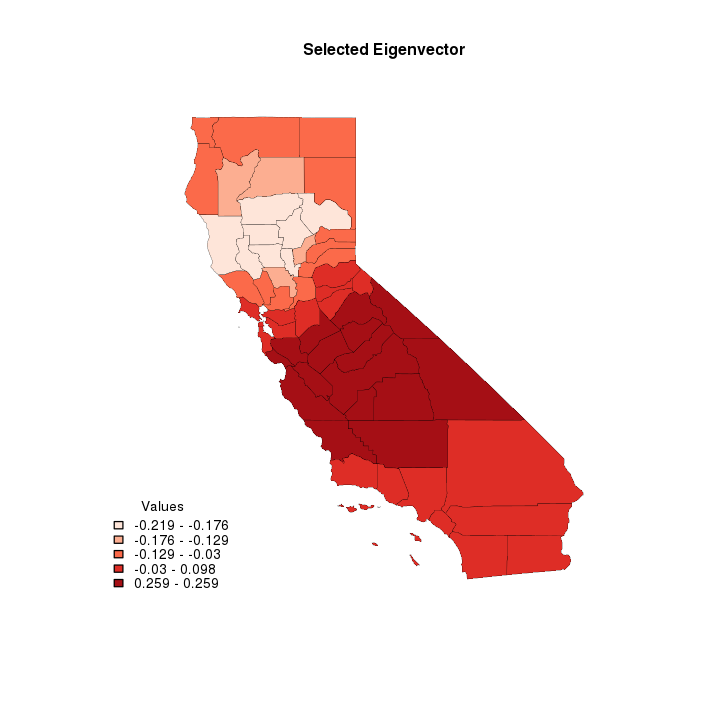

In [96]:
numcat <- 5
pal <- brewer.pal(numcat,"Reds")
q <- classIntervals(EV$EV1, numcat, style="kmeans")
cols <- findColours(q,pal)


plot(inFeaturesSubset, col=cols, lwd=.2,main="Selected Eigenvector",cex.main=.8)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Values",cex=.7)

## Further Refine Set of Eigenvectors

At this point, more eigenvectors were likely retained than are actually necessary to generate a model of spatial autocorrelation. As such, stepwise regression can be used to further refine the set of relevant Eigenvectors.  This process of further refining the set of eigenvectors also helps to make the remaining set of eigenvectors all the more uncorrelated and orthogonal.  

The basic process for applying a stepwise regression is: 

a) specify the full model containing all of the eigenvectors and 

b) apply a stepwise technique to assess which combinations of variables are most significant. 


In the example below, this is done for a linear regression model (lm() function).  In the linear model, the dependent variable and explanatory variable are specified. Then the remaining set of eigenvectors are added to the model as explanatory variables. Next, a stepwise regression is applied to help refine the set of best explanatory variables. This is done using the stepAIC() function (MASS library).  

How many Eigenvectors are selected?  

According to the code, which parameters influence how many Eigenvectors are selected? 

What is the purpose of the 'k' argument in the stepAIC() function?

In [97]:
#populate basic linear model with the subset of eigenvectors
YVar.lm.full <- lm(YVar ~ Exp1 + ., data = EV)

#conduct stepwise regression to spatially filter Eigenvectors
YVar.lm.sf <- stepAIC(YVar.lm.full, 
                          lm(YVar ~ Exp1, data = EV), 
                          direction = "both", 
                          k = 2.7)

#summarize the results of the stepwise regression
summary(YVar.lm.sf)

Start:  AIC=350.15
YVar ~ Exp1 + (EV1 + EV2 + EV3 + EV4 + EV5 + EV6 + EV7 + EV8 + 
    EV9 + EV10 + EV11 + EV12 + EV13 + EV14)

       Df Sum of Sq   RSS    AIC
- EV4   1      7.90 11537 347.49
- EV8   1     33.17 11562 347.61
- EV2   1     52.96 11582 347.71
- EV9   1    146.73 11676 348.18
- EV1   1    213.40 11743 348.51
- EV6   1    231.22 11760 348.60
- EV12  1    250.88 11780 348.70
- EV7   1    361.80 11891 349.24
- EV14  1    424.59 11954 349.55
- EV3   1    468.50 11998 349.76
<none>              11529 350.15
- Exp1  1    588.54 12118 350.34
- EV10  1    636.40 12166 350.56
- EV13  1    815.21 12344 351.41
- EV5   1   2030.77 13560 356.86
- EV11  1   2328.25 13858 358.12

Step:  AIC=347.49
YVar ~ Exp1 + EV1 + EV2 + EV3 + EV5 + EV6 + EV7 + EV8 + EV9 + 
    EV10 + EV11 + EV12 + EV13 + EV14

       Df Sum of Sq   RSS    AIC
- EV8   1     33.06 11570 344.95
- EV2   1     51.91 11589 345.05
- EV9   1    143.35 11680 345.50
- EV1   1    206.64 11744 345.82
- EV6   1    227.32 11764 


Call:
lm(formula = YVar ~ EV3 + EV5 + EV7 + EV11 + EV12 + EV13, data = EV)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.525  -9.429  -0.042   8.135  51.114 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   24.344      2.088  11.660 5.33e-16 ***
EV3          -48.632     15.901  -3.058  0.00354 ** 
EV5          -49.470     15.901  -3.111  0.00305 ** 
EV7           29.819     15.901   1.875  0.06648 .  
EV11          67.946     15.901   4.273 8.43e-05 ***
EV12          25.744     15.901   1.619  0.11161    
EV13         -30.010     15.901  -1.887  0.06481 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.9 on 51 degrees of freedom
Multiple R-squared:  0.4796,	Adjusted R-squared:  0.4183 
F-statistic: 7.832 on 6 and 51 DF,  p-value: 5.324e-06


### Retrieve the Best Eigenvectors from the Stepwise Model

Use the names() function to retrieve the model coeficients associated with the best model. Extract the names of the EV eigenvectors that were involved and build a final version of the best model. Note that the selected eigenvectors are not necessarily the ones that involve the highest unique facets of autocorrelation.  For example, eigenvector 1 was not selected. This is because some portions of autocorrelation may have not been relevant for the dependent variable under analysis.

In [98]:
#retrieve model coef. names
coefnm <- names(coef(YVar.lm.sf))

coefnm

[1] "(Intercept)" "EV3"         "EV5"         "EV7"         "EV11"       
[6] "EV12"        "EV13"

In [99]:
#iterate through the eigenvectors in the best model found and select up to 20 of the best eigenvectors.
exComp <- 20
ctit <- 1

formlist <- list()

formula2 <- c(YVar ~ Exp1)

SelectedEigenvectors <- c()

incnt <- 1

for (ele in coefnm)   {
    #find the coefs. named EV
    if ((ctit <= exComp) && (startsWith(ele,"EV"))) {
        #build upon the new best formulation
        formula2 <- paste(formula2, "+", sep = " ")
        formula2 <- paste(formula2, ele, sep = " ")
        s1 <- unlist(strsplit(ele, split = 'EV', fixed = TRUE))[2]
        formlist[[ctit]] <- as.numeric(s1)
        
        ctit <- ctit + 1
    }
    incnt <- incnt + 1   
}

SelectedEigenvectors <- unlist(formlist)

paste("The selected eigenvectors are: ")
paste("EV",SelectedEigenvectors)
paste("The best model formulation is: ", formula2)

[1] "The selected eigenvectors are: "

[1] "EV 3"  "EV 5"  "EV 7"  "EV 11" "EV 12" "EV 13"

[1] "The best model formulation is:  YVar ~ Exp1 + EV3 + EV5 + EV7 + EV11 + EV12 + EV13"

### Given the selected Eigenvectors, fit spatially filtered model

Include the selected eigenvectors as explanatory variables in the linear model.

In [100]:
# populate model with selected Eigenvectors
YVar.lm.sf <- lm(formula2, data = EV)

# summarize the result of applying the spatial filter
summary(YVar.lm.sf)


Call:
lm(formula = formula2, data = EV)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.738  -9.472   0.618   9.024  49.910 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  27.48420    5.90249   4.656 2.41e-05 ***
Exp1         -0.08873    0.15582  -0.569 0.571633    
EV3         -43.67302   18.22270  -2.397 0.020327 *  
EV5         -48.53441   16.09130  -3.016 0.004017 ** 
EV7          27.52668   16.50556   1.668 0.101623    
EV11         64.75586   16.95932   3.818 0.000372 ***
EV12         23.58287   16.45100   1.434 0.157933    
EV13        -29.66690   16.01851  -1.852 0.069929 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.01 on 50 degrees of freedom
Multiple R-squared:  0.4829,	Adjusted R-squared:  0.4105 
F-statistic: 6.671 on 7 and 50 DF,  p-value: 1.381e-05


### Run the Basic OLS Regression

Let's look at what a basic linear regression would provide us without modeling the eigenvectors. Note the R-square is .1632. The R-squre of the spatially filtered model is .4829. Seems like an improvement to me!

In [101]:
#basic linear model
basic.lm <- lm(YVar ~ Exp1)
summary(basic.lm)


Call:
lm(formula = YVar ~ Exp1)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.322 -15.689  -2.115  10.267  52.243 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  41.9435     5.8944   7.116 2.23e-09 ***
Exp1         -0.4972     0.1505  -3.305  0.00166 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.24 on 56 degrees of freedom
Multiple R-squared:  0.1632,	Adjusted R-squared:  0.1483 
F-statistic: 10.92 on 1 and 56 DF,  p-value: 0.001661


###  Examine Test Statistics for Autocorrelation in Spatial Filter 

Does spatial autocorrelation exists within the spatial filter?  Are the p-values significant? I would hope so!

In [102]:
dim(as.matrix(EV[ , SelectedEigenvectors]))

[1] 58  6

In [103]:
dim(as.matrix(YVar.lm.sf$coefficients[c(-1,-2)]))

[1] 6 1

In [104]:
#analyze autocorrelation test statistics for residuals
sfilter <- as.matrix(EV[ , SelectedEigenvectors]) %*% as.matrix(YVar.lm.sf$coefficients[c(-1,-2)])
sfvector <- as.vector(sfilter)

#apply moran and geary test to residuals
moran.test(sfvector, inFeaturesSubset.listb)
geary.test(sfvector, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  sfvector  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 7.5082, p-value = 2.998e-14
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.592741012      -0.017543860       0.006606901 



	Geary C test under randomisation

data:  sfvector 
weights: inFeaturesSubset.listb 

Geary C statistic standard deviate = 6.0673, p-value = 6.503e-10
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.438600795       1.000000000       0.008561523 


### Visualize Spatial Filter

Finally, take a look at the distribution of the autocorrelation modeled by the eigenvector spatial filter.

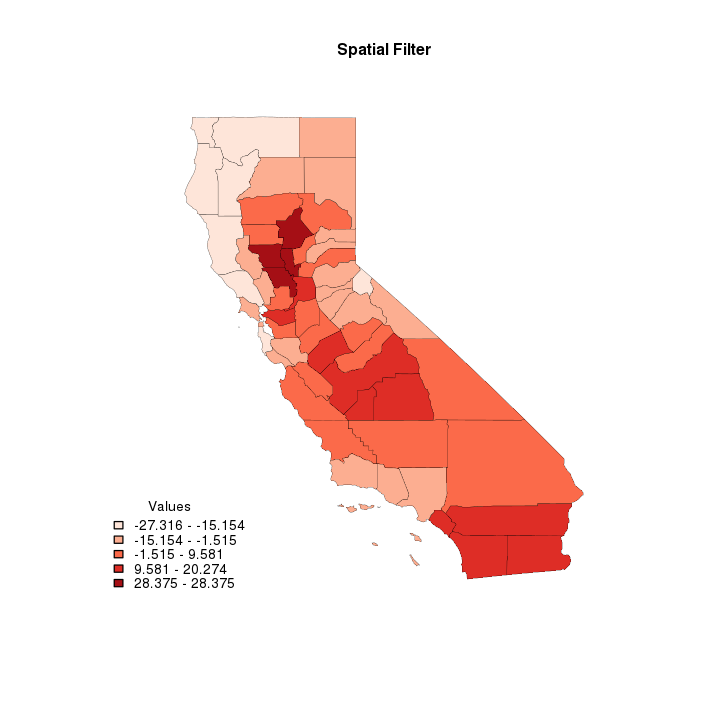

In [105]:
numcat <- 5
pal <- brewer.pal(numcat,"Reds")
q <- classIntervals(sfvector, numcat, style="kmeans")
cols <- findColours(q,pal)


plot(inFeaturesSubset, col=cols, lwd=.2,main="Spatial Filter",cex.main=.8)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Values",cex=.7)